In [2]:
# Start with loading the data
from astropy.table import Table, hstack, vstack
from astropy.io import fits
import urllib.request
import io
import gzip


# Read the training data provided by the original paper
# https://www.homepages.ucl.ac.uk/~ucapola/annz.html
data = Table.read('../example_data/sdss/sdss.ugriz.train', format = 'ascii')
#data2 = Table.read('./sdss.ugriz.test', format = 'ascii')
#data = vstack([data1, data2])
input_data_x = data['col1', 'col2','col3','col4','col5'] #ugriz photometry, from ANNz readme
input_data_y = data['col11'] #redshift




In [ ]:
import numpy as np
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings('ignore')

# Set style and random seeds
np.random.seed(42)
torch.manual_seed(42)

# Device selection
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


def create_model(input_dim, hidden_size, output_dim, depth, activation='tanh'):
    """Create a multi-layer neural network"""
    layers = []

    # Input layer
    layers.append(nn.Linear(input_dim, hidden_size))
    if activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'Sigmoid':
        layers.append(nn.Sigmoid())
    elif activation == 'ReLU':
        layers.append(nn.ReLU())
    elif activation == 'LeakyReLU':
          layers.append(nn.LeakyReLU())


    # Hidden layers
    for _ in range(depth - 1):
        layers.append(nn.Linear(hidden_size, hidden_size))
        if activation == 'tanh':
          layers.append(nn.Tanh())
        elif activation == 'Sigmoid':
          layers.append(nn.Sigmoid())
        elif activation == 'ReLU':
          layers.append(nn.ReLU())
        elif activation == 'LeakyReLU':
          layers.append(nn.LeakyReLU())

    # Output layer
    layers.append(nn.Linear(hidden_size, output_dim))

    return nn.Sequential(*layers)


class WeightedMSELoss(nn.Module):
    """MSE loss with more weight on larger y values"""
    def __init__(self, weight_type='linear'):
        super().__init__()
        self.weight_type = weight_type

    def forward(self, pred, target):
        if self.weight_type == 'linear':
            # Weight proportional to |target|
            weights = 1.0 + torch.abs(target)
        elif self.weight_type == 'sqrt':
            # Less aggressive weighting
            weights = 1.0 + torch.sqrt(torch.abs(target))
        elif self.weight_type == 'inverse_freq':
            # Weight by inverse frequency (if you know distribution)
            weights = torch.ones_like(target)
            # Add your custom weighting logic here

        squared_error = (pred - target) ** 2
        weighted_loss = squared_error * weights
        return weighted_loss.mean()


def train_model(model, x_train, y_train, epochs=2000, lr=0.01, reg_type=None, lambda_reg=0.01, x_val = None, y_val =None, patience = 1000):
    """Train the neural network"""
    criterion = nn.MSELoss()
    #criterion =  nn.HuberLoss(delta=0.5)
    #criterion =  WeightedMSELoss(weight_type='inverse_freq')
    optimizer = optim.Adam(model.parameters(), lr=lr) #use Adam for ANNz too
 
    losses = []
    val_losses = []

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    pbar = tqdm(range(epochs), desc="Training")

    for epoch in pbar:
        # Forward pass
        model.train()
        predictions = model(x_train)
        loss = criterion(predictions, y_train)

        losses.append(loss.item())#pure loss

        # Add regularization if specified
        if reg_type == 'l2':
            l2_reg = torch.tensor(0.)
            for param in model.parameters():
                l2_reg += torch.norm(param, 2)**2 # we include bias terms in it
            loss += lambda_reg * l2_reg
        elif reg_type == 'l1':
            l1_reg = torch.tensor(0.)
            for param in model.parameters():
                l1_reg += torch.norm(param, 1)
            loss += lambda_reg * l1_reg

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #losses.append(loss.item())

        if x_val is not None and y_val is not None:
            model.eval()
            with torch.no_grad():
                val_predictions = model(x_val)
                val_loss = criterion(val_predictions, y_val)
                val_losses.append(val_loss.item()) #MSE loss, RMS is the sqrt(MSE)


        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch}")
            model.load_state_dict(best_model_state)
            break

        if epoch % 10 == 0:
            pbar.set_postfix({
                'Train': f'{loss.item():.6f}',
                'Val': f'{val_loss.item():.6f}',
                'Best': f'{best_val_loss:.6f}',
                'Patience': f'{patience_counter}/{patience}'
            })

    return losses, val_losses


from sklearn.preprocessing import StandardScaler

# Training data
x_training = np.array(input_data_x[:int(len(input_data_x))].to_pandas())
y_training = np.array(input_data_y[:int(len(input_data_y))]).astype('float64')

x_training_flat = x_training.reshape(x_training.shape[0], -1)
print(f"Input shape: {x_training_flat.shape}")

# Standardize the data
scaler_x = StandardScaler()
x_training_scaled = scaler_x.fit_transform(x_training_flat)

scaler_y = StandardScaler()
y_training_scaled = scaler_y.fit_transform(y_training.reshape(-1, 1)).flatten()

# Convert to tensors
x_train_tensor = torch.tensor(x_training_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_training_scaled, dtype=torch.float32).reshape(-1, 1)

#no normalization for ANNz
x_train_tensor_no_scale = torch.tensor(x_training, dtype=torch.float32)
y_train_tensor_no_scale = torch.tensor(y_training, dtype=torch.float32).reshape(-1, 1)


#validation data
data_val = Table.read('../example_data/sdss/sdss.ugriz.valid', format = 'ascii')
input_data_x_val = data_val['col1', 'col2','col3','col4','col5'] #ugriz photometry, from ANNz readme
input_data_y_val = data_val['col11'] #redshift

x_valid = np.array(input_data_x_val.to_pandas())
y_valid = np.array(input_data_y_val).astype('=f8') #80% training

#Normalize the data to 0,1

x_val_flat = x_valid.reshape(x_valid.shape[0], -1)

# Normalize X
x_val_scaled=  scaler_x.transform(x_val_flat)
y_val_scaled = scaler_y.transform(y_valid.reshape(-1, 1)).flatten()

x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32).reshape(-1, 1)

x_val_tensor_no_scale = torch.tensor(x_valid, dtype=torch.float32)
y_val_tensor_no_scale = torch.tensor(y_valid, dtype=torch.float32).reshape(-1, 1)

def ANNz_original():

  # Create and train model
  model = create_model(
      input_dim=x_training_flat.shape[1],  # 5
      hidden_size=10,
      output_dim=1,
      depth=2,
      activation='Sigmoid',

  )

  print(f"\nModel architecture:\n{model}")

  # Train
  losses, val_losses = train_model(
      model,
      x_train_tensor_no_scale,
      y_train_tensor_no_scale,
      epochs=1000, #following the paper
      lr=0.01,
      reg_type='l2',
      lambda_reg=0.0001,
      x_val = x_val_tensor_no_scale,
      y_val = y_val_tensor_no_scale
  )

  return model, losses, val_losses


def update_SDSS():

  # Create and train model
  model = create_model(
      input_dim=x_training_flat.shape[1],  # 5
      hidden_size=16,
      output_dim=1,
      depth=3,
      activation='ReLU',

   )

  print(f"\nModel architecture:\n{model}")

  # Train
  losses, val_losses = train_model(
      model,
      x_train_tensor,
      y_train_tensor,
      epochs=1000, #following the paper
      lr=0.01,
      reg_type='l2',
      lambda_reg=0.01,
      x_val = x_val_tensor,
      y_val = y_val_tensor
  )

  return model, losses, val_losses


model_ANNz, losses_ANNz, val_losses_ANNz = ANNz_original()
model_update_SDSS, losses_update_SDSS, val_losses_update_SDSS = update_SDSS()



Input shape: (5000, 5)

Model architecture:
Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=10, out_features=1, bias=True)
)


Training: 100%|██████████| 1000/1000 [00:01<00:00, 927.32it/s, Train=0.003899, Val=0.004159, Best=0.002634, Patience=363/1000]



Model architecture:
Sequential(
  (0): Linear(in_features=5, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=1, bias=True)
)


Training: 100%|██████████| 1000/1000 [00:01<00:00, 604.19it/s, Train=0.150437, Val=0.101812, Best=0.100710, Patience=22/1000]


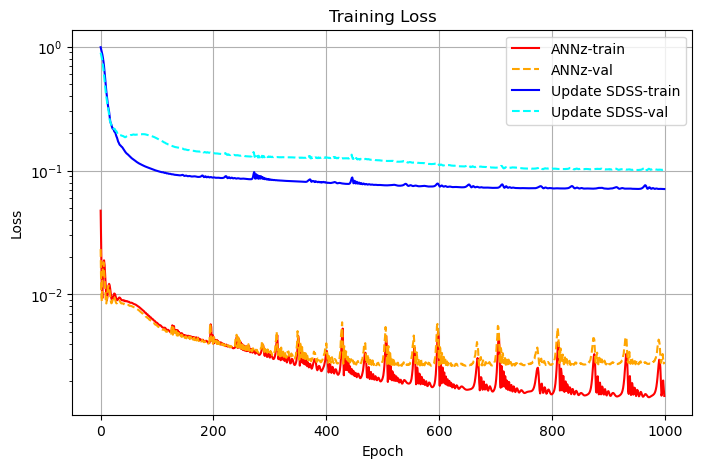


Final loss: 0.001510
Final loss: 0.070904


In [4]:
# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(range(len(losses_ANNz)), losses_ANNz, label='ANNz-train', c = 'r')
plt.plot(range(len(val_losses_ANNz)), val_losses_ANNz, label='ANNz-val', c = 'orange', ls = '--')

plt.plot(range(len(losses_update_SDSS)),losses_update_SDSS, label='Update SDSS-train', c = 'b')
plt.plot(range(len(val_losses_update_SDSS)),val_losses_update_SDSS, label='Update SDSS-val', c = 'cyan', ls = '--')

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()
plt.show()

print(f"\nFinal loss: {losses_ANNz[-1]:.6f}")
print(f"Final loss: {losses_update_SDSS[-1]:.6f}")

In [6]:
data_test = Table.read('../example_data/sdss/sdss.ugriz.test', format = 'ascii')
input_data_x_test = data_test['col1', 'col2','col3','col4','col5'] #ugriz photometry, from ANNz readme
input_data_y_test= data_test['col11'] #redshift

x_test = np.array(input_data_x_test.to_pandas())
y_test = np.array(input_data_y_test).astype('=f8') #80% training

#Normalize the data to 0,1

x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Normalize X
x_test_scaled=  scaler_x.transform(x_test_flat)


# Normalize outputs by dividing by 15, z range normally is [0,15]
y_test_scaled = y_test / 1  # Now in [0, 1]

x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

x_test_tensor_no_scale = torch.tensor(x_test, dtype=torch.float32)

model = model_update_SDSS
model.eval()
with torch.no_grad():
      y_pred = model(x_test_tensor).numpy().flatten()
      x_test_np = x_test_tensor.numpy().flatten()


model = model_ANNz
model.eval()
with torch.no_grad():
      y_pred_ANNz = model(x_test_tensor_no_scale).numpy().flatten()
      x_test_np = x_test_tensor.numpy().flatten()

L2_error is 0.030487677313589014
L2_error is 0.04279655139168997


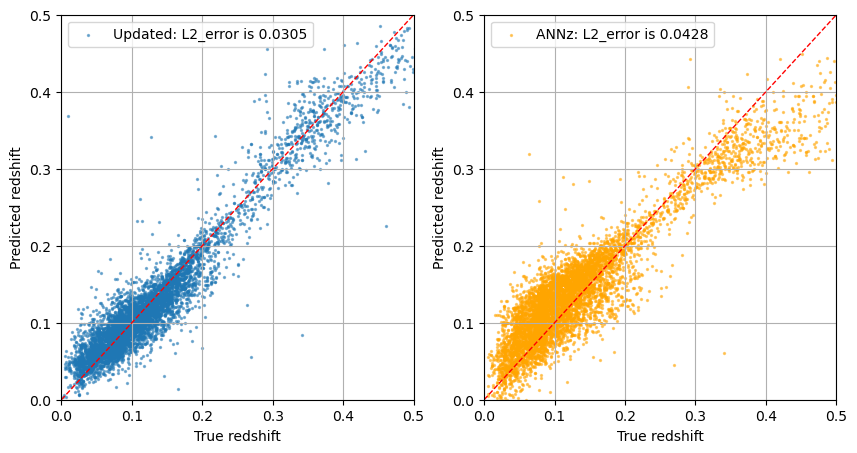

In [7]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
y_real_value = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

L2_error = np.sqrt(np.mean(((y_test-y_real_value.flatten())**2)))
print(f'L2_error is {L2_error}')

ax = axs[0]
ax.scatter(y_test, y_real_value, s = 2, label = f'Updated: L2_error is {round(L2_error,4)}', alpha = 0.5)
ax.plot([0,1],[0,1], lw = 1, ls = '--', c = 'r')
ax.set_xlim(0,0.5)
ax.set_ylim(0,0.5)
ax.set_xlabel('True redshift')
ax.set_ylabel('Predicted redshift')


ax.legend()
ax.grid()

ax = axs[1]
y_real_value = y_pred_ANNz.reshape(-1, 1)#scaler_y.inverse_transform(y_pred_ANNz.reshape(-1, 1))
L2_error = np.sqrt(np.mean(((y_test-y_real_value.flatten())**2)))
print(f'L2_error is {L2_error}')

ax.scatter(y_test, y_real_value, s = 2, label = f'ANNz: L2_error is {round(L2_error,4)}', c = 'orange', alpha = 0.5)
ax.plot([0,1],[0,1], lw = 1, ls = '--', c = 'r')
ax.set_xlim(0,0.5)
ax.set_ylim(0,0.5)
ax.set_xlabel('True redshift')
ax.set_ylabel('Predicted redshift')


ax.legend()
ax.grid()